In [1]:
import glob
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
from matplotlib import pyplot as plt
from natsort import natsorted

## Read dataset

In [2]:
all_files = natsorted(glob.glob(os.path.join('./trackkick_results/',"*.res")))
kick_list = []
for file in all_files: 
    df=pd.read_csv(file , sep= ",", header='infer')
    df["kick"] = int(file[30:-4])
    df.columns=df.columns.str.strip()
    kick_list.append(df)

In [3]:
all_files[:5]

['./trackkick_results\\trackkick_1.res',
 './trackkick_results\\trackkick_2.res',
 './trackkick_results\\trackkick_3.res',
 './trackkick_results\\trackkick_4.res',
 './trackkick_results\\trackkick_5.res']

#### Inspect data

In [4]:
kick_list[3]

,time,GT_distance,GT_height,See_distance,See_height,Gyro_rates,kick
0,0.02,0.000,0.0,0.010497,-0.005173,27.11,4
1,0.04,0.000,0.0,0.002875,-0.006686,31.82,4
2,0.06,0.000,0.0,0.007317,0.003766,33.57,4
3,0.08,0.000,0.0,0.009044,0.000136,5.51,4
4,0.10,0.000,0.0,0.014313,-0.000237,7.00,4
...,...,...,...,...,...,...,...
290,5.82,5.486,0.0,5.485230,0.000564,-24.96,4
291,5.84,5.486,0.0,5.493100,-0.001385,13.35,4
292,5.86,5.486,0.0,5.492830,-0.005239,-22.53,4
293,5.88,5.486,0.0,5.493040,-0.003317,-1.21,4


## Investigate a selected kick

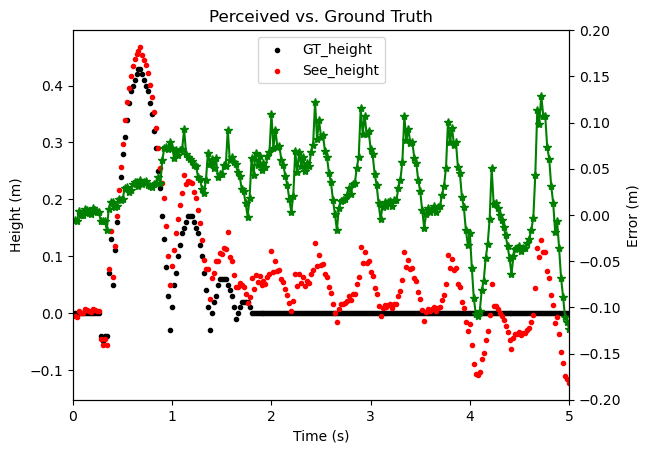

In [5]:
df_data = kick_list[3]
plt.scatter(df_data['time'], df_data['GT_height'] ,marker=".",color="black")
plt.scatter(df_data['time'], df_data['See_height'] ,marker=".",color="red")
plt.title("Perceived vs. Ground Truth")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.xlim([0,5])
plt.legend(["GT_height","See_height"],loc='upper center')
plt.twinx()
plt.plot(df_data['time'], df_data['See_height']-df_data['GT_height'] ,marker="*",color="g")
plt.ylabel("Error (m)")
plt.ylim([-0.2,0.2])
plt.show()

Worse error as ball moves further away. Since the noise of the server perceptors is removed, no error is expected. The cyclic nature may be related to the walking in place of the robot so possibly the transform is missing the uprightedness orientation changes of the robot (Check l2g function)

In [ ]:
df_data = kick_list[3]
plt.plot(df_data['time'], df_data['See_height']-df_data['GT_height'] ,marker="*",color="g")
plt.title("Perception error vs. Gyro Y Axis")
plt.xlabel("Time (s)")
plt.xlim([0,5])
plt.ylabel("Error (m)")
plt.legend(["Error"],loc='upper center')
plt.twinx()
plt.plot(df_data['time'], df_data['Gyro_rates'],marker="*",color="b", alpha=0.3)
plt.ylim([-160,160])
plt.ylabel("Gyro rate (m/s^2)")
plt.legend(["Gyro"],loc='lower center')
plt.show()

There is a high correleation between the angular acceleration of the Y axis gyro and the error. They appear to have the same frequency. The transform does not seem to account for lack of uprightness

## Plot all kicks

In [ ]:
fig,axes = plt.subplots(nrows=5, ncols=2, figsize=(12,12))#, sharex=True, sharey=True)

axes_list=axes.ravel()

for i, ax in enumerate(axes_list):
    df_data = kick_list[i]
    ax.scatter(df_data['GT_distance'], df_data['GT_height'] ,marker=".",color="black")
    ax.scatter(df_data['See_distance'], df_data['See_height'] ,marker=".",color="red")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Height (m)")

plt.show()

Some non-physical measurement feedback is received since its clear that the ground truth shows it as being below the ground and at an offset position... This does may impact the accuracy of our kicking because the server repeats the kick command for multiple time steps